<a href="https://colab.research.google.com/github/mariokart345/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

In [ ]:
!pip install category_encoders==2.*
!pip install pandas_profiling==2.*
!pip install eli5
data = 'https://raw.githubusercontent.com/mariokart345/DS-Unit-2-Applied-Modeling/master/data/Video_Games_Sales_as_at_22_Dec_2016.csv'

In [ ]:
import pandas as pd
df = pd.read_csv(data)

In [ ]:
import numpy as np
def wrangle(df):
    #Engineering features
    df['Above_Average_Critic_Score'] = df['Critic_Score']>70
    df['User_Score'] = df['User_Score'].replace('tbd',np.NaN,regex=True)
    df['User_Score'] = df['User_Score'].astype(float)
    df['Above_Average_User_Score'] = df['User_Score']>7
    #Dropping really high variance
    df = df.drop(labels=['Name','Developer'],axis=1)
    #Dropping high NaN columns
    df = df.drop(labels=['Rating','User_Count','User_Score','Critic_Count','Critic_Score'],axis=1)
    #Using log function to created a less skewed distribution
    df['Log_Global_Sales'] = np.log1p(df['Global_Sales'])
    #Dropping Sales columns to prevent leakage
    df = df.drop(labels=['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales'],axis=1)
    #Converting 'Year_of_Release' to pandas datetime
    df['Year_of_Release'] = pd.to_datetime(df['Year_of_Release'],format='%Y')
    df['Year_of_Release'] = df['Year_of_Release'].dt.year
    #Removing upper and lower .5 percentile
    df = df[(df['Log_Global_Sales'] >= np.percentile(df['Log_Global_Sales'], 0.5)) & (df['Log_Global_Sales'] <= np.percentile(df['Log_Global_Sales'], 99.5))]
    return df

In [ ]:
game_sales = wrangle(df)

In [ ]:
game_sales.head()

,Platform,Year_of_Release,Genre,Publisher,Above_Average_Critic_Score,Above_Average_User_Score,Log_Global_Sales
84,PS2,2001.0,Role-Playing,Sony Computer Entertainment,True,True,2.202765
85,PC,2009.0,Simulation,Electronic Arts,True,True,2.198335
86,Wii,2007.0,Sports,Sega,False,False,2.196113
87,PS4,2015.0,Shooter,Electronic Arts,False,False,2.195000
88,PS,1999.0,Role-Playing,SquareSoft,True,True,2.181547


In [ ]:
from sklearn.model_selection import train_test_split
train,val = train_test_split(game_sales,train_size=0.8,test_size=0.2,random_state=25)
#Dropping 'Global_Sales' to prevent leakage and splitting into features and target
y_train = train['Log_Global_Sales']
X_train = train.drop('Log_Global_Sales',axis=1)
y_val = val['Log_Global_Sales']
X_val = val.drop('Log_Global_Sales',axis=1)

In [ ]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(ce.OrdinalEncoder(),SimpleImputer(strategy='mean'),LinearRegression())
pipeline.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Platform', 'Genre', 'Publisher'],
                                mapping=[{'col': 'Platform',
                                          'data_type': dtype('O'),
                                          'mapping': GBA      1
PS3      2
PS       3
X360     4
PSP      5
PS2      6
DS       7
SNES     8
XB       9
PSV     10
PS4     11
PC      12
3DS     13
2600    14
GB      15
SAT     16
Wii     17
GC      18
WiiU    19
GEN     20
N64     21
XOne    22
NES     23
PCFX    24
DC      25
SCD     26
NG      27
3DO     28
TG16    29
WS      30
GG      31
NaN     -2
dtype: int64},
                                         {'col': 'Genre',
                                          'data_type': dtype('O'),
                                          'map...
Racing           8
Platform         9
Sports          10
Strategy        11
Shooter         12
NaN             13
dtype: int64},
                                        

In [ ]:
from sklearn.metrics import r2_score
y_train_pred = pipeline.predict(X_train)
y_val_pred = pipeline.predict(X_val)
print(f'Training R^2:{r2_score(y_train,y_train_pred)}\nValidation R^2:{r2_score(y_val,y_val_pred)}')

Training R^2:0.1463618549453095
Validation R^2:0.128945881086445


Changing the problem to Classification through a previously engineered feature as the target

In [ ]:
from sklearn.model_selection import train_test_split
train,val = train_test_split(game_sales,train_size=0.8,test_size=0.2,random_state=25)
#Dropping 'Global_Sales' to prevent leakage and splitting into features and target
y_train = train['Above_Average_User_Score']
X_train = train.drop('Above_Average_User_Score',axis=1)
y_val = val['Above_Average_User_Score']
X_val = val.drop('Above_Average_User_Score',axis=1)

In [ ]:
#Baseline
from sklearn.metrics import accuracy_score
mean = y_train.mode()[0]
y_pred = [mean]*len(y_train)
baseline_acc = accuracy_score(y_train,y_pred)
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.7223474601743313


In [ ]:
#Simple Model
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
pipeline = make_pipeline(ce.OrdinalEncoder(),SimpleImputer(strategy='mean'),RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
pipeline.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Platform', 'Genre', 'Publisher'],
                                mapping=[{'col': 'Platform',
                                          'data_type': dtype('O'),
                                          'mapping': GBA      1
PS3      2
PS       3
X360     4
PSP      5
PS2      6
DS       7
SNES     8
XB       9
PSV     10
PS4     11
PC      12
3DS     13
2600    14
GB      15
SAT     16
Wii     17
GC      18
WiiU    19
GEN     20
N64     21
XOne    22
NES     23
PCFX    24
DC      25
SCD     26
NG      27
3DO     28
TG16    29
WS      30
GG      31
NaN     -2
dtype: int64},
                                         {'col': 'Genre',
                                          'data_type': dtype('O'),
                                          'map...
Shooter         12
NaN             13
dtype: int64},
                                         {'col': 'Publisher',
                                          'data_type':

In [ ]:
#Mode score is better than the baseline score
pipeline.score(X_val,y_val)

0.8458070333633905

In [ ]:
#Transforming data and training new model for Permutation Importance
transformers = make_pipeline(ce.OrdinalEncoder(), SimpleImputer(strategy='mean'))
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
model = RandomForestClassifier(n_estimators=50, random_state=79, n_jobs=-1)
model.fit(X_train_transformed, y_train)
#Permutation Importance
import eli5
from eli5.sklearn import PermutationImportance
permuter = PermutationImportance(model,scoring='accuracy',n_iter=10,random_state=76)
permuter.fit(X_val_transformed,y_val)
feature_names = X_val.columns.to_list()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.2075 ± 0.0105,Above_Average_Critic_Score
0.0154 ± 0.0038,Log_Global_Sales
0.0147 ± 0.0075,Year_of_Release
0.0079 ± 0.0050,Publisher
0.0075 ± 0.0060,Genre
0.0023 ± 0.0038,Platform


In [ ]:
#Trying XGBoost
from xgboost import XGBClassifier
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
model = XGBClassifier(n_estimators=500,max_depth=6,learning_rate=0.5,n_jobs=4)
eval_set = [(X_train_encoded,y_train),(X_val_encoded,y_val)]
model.fit(X_train_encoded,y_train,eval_set=eval_set,eval_metric='logloss',early_stopping_rounds=25)

[0]	validation_0-logloss:0.48435	validation_1-logloss:0.49006
[1]	validation_0-logloss:0.40647	validation_1-logloss:0.42088
[2]	validation_0-logloss:0.37192	validation_1-logloss:0.39040
[3]	validation_0-logloss:0.35335	validation_1-logloss:0.37836
[4]	validation_0-logloss:0.34119	validation_1-logloss:0.37002
[5]	validation_0-logloss:0.33370	validation_1-logloss:0.36391
[6]	validation_0-logloss:0.32671	validation_1-logloss:0.36344
[7]	validation_0-logloss:0.32165	validation_1-logloss:0.36067
[8]	validation_0-logloss:0.31575	validation_1-logloss:0.35924
[9]	validation_0-logloss:0.31116	validation_1-logloss:0.35957
[10]	validation_0-logloss:0.30831	validation_1-logloss:0.35883
[11]	validation_0-logloss:0.30549	validation_1-logloss:0.35954
[12]	validation_0-logloss:0.30228	validation_1-logloss:0.36004
[13]	validation_0-logloss:0.29796	validation_1-logloss:0.36006
[14]	validation_0-logloss:0.29501	validation_1-logloss:0.36002
[15]	validation_0-logloss:0.29332	validation_1-logloss:0.35944
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.5, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

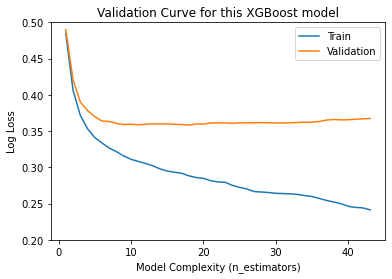

In [ ]:
#Ploting Log loss for validation_0 and validation_1
%matplotlib inline
import matplotlib.pyplot as plt
results = model.evals_result()
train_error = results['validation_0']['logloss']
val_error = results['validation_1']['logloss']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Log Loss')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
plt.ylim((0.20, 0.50))
plt.legend();